## tasks
### 1: Form training and testing periods as discussed (2 test periods, last 2*365 days). Be careful tp scale data only based on data from the training set. You may use (from Python) MinMaxScaler, standardisation (StandardScaler) or the default scaler in Python's elastic net.
### 2:Estimate the current flu rates by training an elastic net model. Use a Pearson correlation filter (r > 0.3) on the training data to reduce the amount of queries prior to training an elastic net (reminder: not all 1000 queries I provided are related to flu!). Report performance on the two test sets using three metrics: mean absolute error, root mean squared error and Pearson's correlation.
### 3: If there is time, begin work on traditional forecasting models (you've identified seasonal ARIMA and Hult-Winters).

In [15]:
# import libraries
import numpy as np
import pandas as pd
import random
import csv
import scipy.stats as stats
import seaborn as sns
from collections import Counter
from collections import defaultdict
import math
from sklearn.linear_model import ElasticNet
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from random import randint

import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm

# initialize the plotting sizes
# set size
plt.rc('figure', figsize=(15, 8))
# subplots size
fizsize_with_subplots = (15, 8)
# histogram size
bin_size = 10

In [2]:
# Loading data
dates = pd.read_csv('data/dates.csv',header=None)
queries = pd.read_csv('data/queries.csv',header=None)
X = pd.read_csv('data/X.csv',header=None)
y = pd.read_csv('data/y.csv',header=None)

X.columns = queries

In [3]:
# data preprocessing and train-test split
# this data is well formed with no missing value and other symbols or labels that are non numerical.
# splitting the data into train and test

# Here we want the first 500 queries
X = X.iloc[:, 0: 250]

# first with the last year as test
# for convinience, pick the two validation set starting from 1/3 and 2/3 of the training set,
# 10% of training set as validation, here use 400 data points, two 200 periods.
test_size =365
length = X.shape[0]
l =(X.shape[0]-test_size)//3

train1_X = pd.concat([X[0:l],X[l+200:2*l],X[2*l+200:length-test_size]])
val1_X = pd.concat([X[l:l+200],X[2*l:2*l+200]])
train1_y = pd.concat([y[0:l],y[l+200:2*l],y[2*l+200:length-test_size]])
val1_y = pd.concat([y[l:l+200],y[2*l:2*l+200]])
test1_X = X[length-test_size:]
test1_y = y[length-test_size:]

# second with the last 2 year as test
test_size2 =365*2
l2 =(X.shape[0]-test_size2)//3

train2_X = pd.concat([X[0:l2],X[l2+180:2*l2],X[2*l2+180:length-test_size2]])
val2_X = pd.concat([X[l2:l2+180],X[2*l2:2*l2+180]])
train2_y = pd.concat([y[0:l2],y[l2+180:2*l2],y[2*l2+180:length-test_size2]])
val2_y = pd.concat([y[l2:l2+180],y[2*l2:2*l2+180]])
test2_X = X[length-test_size2:length-test_size]
test2_y = y[length-test_size2:length-test_size]

print('X shape: ',X.shape,'  y shape: ',y.shape)
print('train1 X:',train1_X.shape,' train1 y:',train1_y.shape,' Test1 X shape:',test1_X.shape, ' Test1 y shape:',test1_y.shape)
print('validation1 X:',val1_X.shape,' validation1 y:',val1_y.shape)
print('train2 X:',train2_X.shape,' train2 y:',train2_y.shape,' Test2 X:',test2_X.shape,' Test2 y:',test2_y.shape)
print('validation2 X:',val2_X.shape,' validation2 y:',val2_y.shape)

X shape:  (4383, 250)   y shape:  (4383, 1)
train1 X: (3618, 250)  train1 y: (3618, 1)  Test1 X shape: (365, 250)  Test1 y shape: (365, 1)
validation1 X: (400, 250)  validation1 y: (400, 1)
train2 X: (3293, 250)  train2 y: (3293, 1)  Test2 X: (365, 250)  Test2 y: (365, 1)
validation2 X: (360, 250)  validation2 y: (360, 1)


In [4]:
train_size = train1_X.shape[0]
corrs = np.zeros((X.shape[1],1))
for i in range(0,X.shape[1]):
    if X.sum(axis=1)[i] == 0:
        corrs[i] = 0
    else:
        corrs[i] = np.corrcoef(train1_X.iloc[0:train_size,i],train1_y.iloc[0:train_size,0])[0,1]
        
corrs.shape,X.columns.shape,X.columns[0],X.columns[249]

((250, 1), (250,), ('flu',), ('flu incubation',))

In [5]:
def corr_filter(df_X,df_Xval,df_Xtest,corrs,threshold):
    X = df_X.copy()
    X_test = df_Xtest.copy()
    X_val = df_Xval.copy()
    col_corr = set() # Set of all the names of deleted columns
    for i in range(0,250):
            if corrs[i,0] < threshold: 
                #print(X.columns[i])
                colname = df_X.columns[i]
                del X[colname] # deleting the column from the dataset
                del X_test[colname] 
                del X_val[colname]

    return X,X_val,X_test

## Fixing pearson correlation filter r>=0.2

In [6]:
#train1_X0,test1_X0 = corr_filter(train1_X,test1_X,corrs,0.1)
train1_X1,val1_X1,test1_X1 = corr_filter(train1_X,val1_X,test1_X,corrs,0.2)
#train1_X2,test1_X2 = corr_filter(train1_X,test1_X,corrs,0.3)
#train1_X3,test1_X3 = corr_filter(train1_X,test1_X,corrs,0.4)

In [7]:
#print('For correlation filter r>=0.1, we select feature number: ',train1_X0.shape[1])
print('For correlation filter r>=0.2, we select feature number: ',train1_X1.shape[1])
#print('For correlation filter r>=0.3, we select feature number: ',train1_X2.shape[1])
#print('For correlation filter r>=0.4, we select feature number: ',train1_X3.shape[1])

For correlation filter r>=0.2, we select feature number:  149


In [8]:
# Defien the mearure matrics, MAE, RMSE, CORR
# define three metrics: mean absolute error, root mean squared error and Pearson's correlation.
from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(y_actual, y_pred)

from sklearn.metrics import mean_squared_error
from math import sqrt
# rmse = sqrt(mean_squared_error(y_actual, y_pred))

# np.correcoef returns Pearson product-moment correlation coefficients
def pearson_r(x,y):   
    corr_mat = np.corrcoef(x,y)
    return corr_mat[0,1]
# r = pearson_r(y_actual,y_pred)


# Generalise the function for convinient tuning
def eNet(a,l,train_X,train_y,test_X,test_y):
    
    # scaling and modeling
    scalerX = StandardScaler()
    scalerX.fit(train_X)
    train_X = scalerX.transform(train_X)
    test_X = scalerX.transform(test_X)
    
    scalery = StandardScaler() 
    scalery.fit(train_y) 
    train_y = scalery.transform(train_y) 
    
    
    alpha = a
    l1_ratio = l
    enet = ElasticNet(alpha=a, l1_ratio=l, normalize=False,max_iter=10000)
    enet.fit(train_X,train_y)
    print('Nonzero weights: %d from %d' % (len(np.nonzero(enet.coef_)[0]), len(enet.coef_)))
    y_pred1 = enet.predict(test_X)
    y_pred1 = scalery.inverse_transform(y_pred1)

    mae1 = mean_absolute_error(test_y, y_pred1)
    #print('The mean absolute error is: ',mae1)

    rmse1 = sqrt(mean_squared_error(test_y, y_pred1))
    #print('The root mean squared error is: ',rmse1)
    
    corr_y = test_y.copy()
    corr_y['y_act'] = test_y
    corr_y['y_pred']= y_pred1
    corr = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]
    #print('The correlation is: ',corr)
    
    return rmse1, mae1,corr
    
    


para = [10]
para_l=[0.3]
print('For correlation filter r>=0.1, 310 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X0,train1_y,test1_X0,test1_y))

In [9]:
print(train1_X1.shape,val1_X1.shape)
train3_X = train1_X1.append(val1_X1)
train3_y = train1_y.append(val1_y)
train3_X.shape,train3_y.shape

(3618, 149) (400, 149)


((4018, 149), (4018, 1))

In [10]:
## Fixing l1-ratio = 0.3, only tuning alpha.
para = np.arange(0.01, 2.0, 0.01)
para_l=[0.3]
rmse=100000
mae=1000000
corr=0
print('For correlation filter r>=0.2, 212 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        rmse0,mae0,corr0 = eNet(a,l,train1_X1,train1_y,val1_X1,val1_y)
        if rmse0< rmse:
            rmse=rmse0
            mae=mae0
            corr = corr0
            print('========================================')
            print('Best RMSE is updated! ' )
            print('The mean absolute error is: ',mae)
            print('The root mean squared error is: ',rmse)
            print('The correlation is: ',corr)
            print('----------------------------------------')
        

For correlation filter r>=0.2, 212 features are selected
alpha: 0.01  L1-ratio: 0.3
Nonzero weights: 118 from 149
Best RMSE is updated! 
The mean absolute error is:  18.851353459724713
The root mean squared error is:  36.645883525869905
The correlation is:  0.8045932637883493
----------------------------------------
alpha: 0.02  L1-ratio: 0.3
Nonzero weights: 106 from 149
alpha: 0.03  L1-ratio: 0.3
Nonzero weights: 87 from 149
alpha: 0.04  L1-ratio: 0.3
Nonzero weights: 78 from 149
Best RMSE is updated! 
The mean absolute error is:  18.21683097242791
The root mean squared error is:  34.28995147895735
The correlation is:  0.85043273609348
----------------------------------------
alpha: 0.05  L1-ratio: 0.3
Nonzero weights: 69 from 149
Best RMSE is updated! 
The mean absolute error is:  17.143906065132317
The root mean squared error is:  32.00363978269034
The correlation is:  0.8559264913354877
----------------------------------------
alpha: 0.060000000000000005  L1-ratio: 0.3
Nonzero wei

Nonzero weights: 26 from 149
Best RMSE is updated! 
The mean absolute error is:  9.567787573624024
The root mean squared error is:  16.01361868998736
The correlation is:  0.885385446376984
----------------------------------------
alpha: 0.34  L1-ratio: 0.3
Nonzero weights: 25 from 149
Best RMSE is updated! 
The mean absolute error is:  9.506559188927415
The root mean squared error is:  15.877796476141398
The correlation is:  0.8854971826230773
----------------------------------------
alpha: 0.35000000000000003  L1-ratio: 0.3
Nonzero weights: 25 from 149
Best RMSE is updated! 
The mean absolute error is:  9.446211954026946
The root mean squared error is:  15.742226747251037
The correlation is:  0.8856172576588346
----------------------------------------
alpha: 0.36000000000000004  L1-ratio: 0.3
Nonzero weights: 24 from 149
Best RMSE is updated! 
The mean absolute error is:  9.384513770988098
The root mean squared error is:  15.601825194795278
The correlation is:  0.8857484094160681
----

Nonzero weights: 14 from 149
Best RMSE is updated! 
The mean absolute error is:  8.364794561244093
The root mean squared error is:  13.361378884780414
The correlation is:  0.8860874234789436
----------------------------------------
alpha: 0.61  L1-ratio: 0.3
Nonzero weights: 14 from 149
Best RMSE is updated! 
The mean absolute error is:  8.326437515653598
The root mean squared error is:  13.284551097778348
The correlation is:  0.8860745844551048
----------------------------------------
alpha: 0.62  L1-ratio: 0.3
Nonzero weights: 13 from 149
Best RMSE is updated! 
The mean absolute error is:  8.288125666126179
The root mean squared error is:  13.210395828585446
The correlation is:  0.8860522704042763
----------------------------------------
alpha: 0.63  L1-ratio: 0.3
Nonzero weights: 13 from 149
Best RMSE is updated! 
The mean absolute error is:  8.24948105868982
The root mean squared error is:  13.139174665844013
The correlation is:  0.8860164543559025
---------------------------------

Nonzero weights: 11 from 149
alpha: 0.93  L1-ratio: 0.3
Nonzero weights: 10 from 149
alpha: 0.9400000000000001  L1-ratio: 0.3
Nonzero weights: 10 from 149
alpha: 0.9500000000000001  L1-ratio: 0.3
Nonzero weights: 9 from 149
alpha: 0.9600000000000001  L1-ratio: 0.3
Nonzero weights: 9 from 149
alpha: 0.97  L1-ratio: 0.3
Nonzero weights: 9 from 149
alpha: 0.98  L1-ratio: 0.3
Nonzero weights: 9 from 149
alpha: 0.99  L1-ratio: 0.3
Nonzero weights: 9 from 149
alpha: 1.0  L1-ratio: 0.3
Nonzero weights: 9 from 149
alpha: 1.01  L1-ratio: 0.3
Nonzero weights: 9 from 149
alpha: 1.02  L1-ratio: 0.3
Nonzero weights: 9 from 149
alpha: 1.03  L1-ratio: 0.3
Nonzero weights: 9 from 149
alpha: 1.04  L1-ratio: 0.3
Nonzero weights: 9 from 149
alpha: 1.05  L1-ratio: 0.3
Nonzero weights: 9 from 149
alpha: 1.06  L1-ratio: 0.3
Nonzero weights: 9 from 149
alpha: 1.07  L1-ratio: 0.3
Nonzero weights: 9 from 149
alpha: 1.08  L1-ratio: 0.3
Nonzero weights: 9 from 149
alpha: 1.09  L1-ratio: 0.3
Nonzero weights: 9 fr

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.3, 150 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X2,train1_y,test1_X2,test1_y))

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.4, 103 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X3,train1_y,test1_X3,test1_y))

In [12]:
## tuned alpha based on validation set, then measure the performance for test set.
## Fixing l1-ratio = 0.3
para = [0.9]
para_l=[0.3]
rmse=100000
mae=1000000
corr=0
print('For correlation filter r>=0.2, 212 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        rmse0,mae0,corr0 = eNet(a,l,train3_X,train3_y,test1_X1,test1_y)
        if rmse0< rmse:
            rmse=rmse0
            mae=mae0
            corr = corr0
            print('========================================')
            print('Best RMSE is updated! ' )
            print('The mean absolute error is: ',mae)
            print('The root mean squared error is: ',rmse)
            print('The correlation is: ',corr)
            print('----------------------------------------')

For correlation filter r>=0.2, 212 features are selected
alpha: 0.9  L1-ratio: 0.3
Nonzero weights: 18 from 149
Best RMSE is updated! 
The mean absolute error is:  4.442888947544031
The root mean squared error is:  4.884453715337612
The correlation is:  0.8241484190739394
----------------------------------------


In [13]:
enet = ElasticNet(alpha=0.9, l1_ratio=0.3, normalize=False,max_iter=10000)
enet.fit(train3_X,train3_y)

y_pred1 = enet.predict(test1_X1)

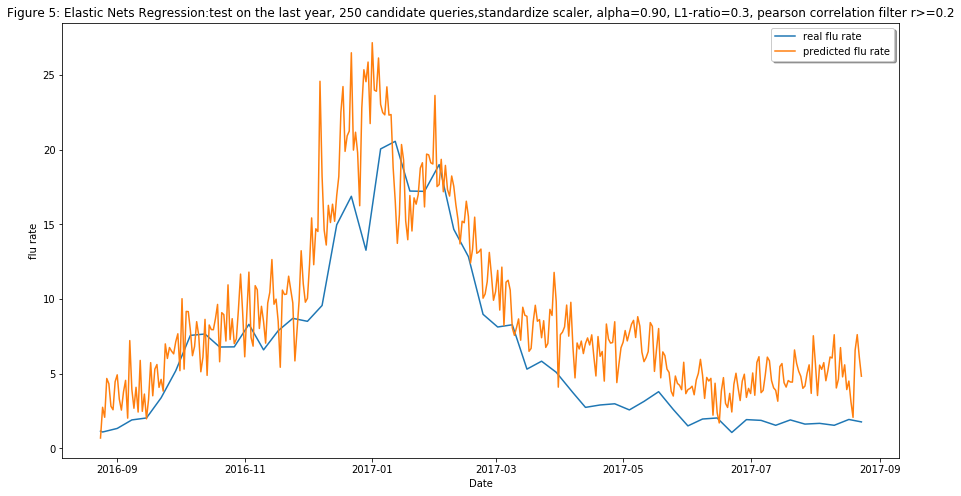

In [17]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],y_pred1,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
plt.title("Figure 5: Elastic Nets Regression:test on the last year, 250 candidate queries,standardize scaler, alpha=0.90, L1-ratio=0.3, pearson correlation filter r>=0.2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

## For the last 2 years as the testing set

In [29]:
train_size2 = train2_X.shape[0]
corrs2 = np.zeros((X.shape[1],1))
for i in range(0,X.shape[1]):
    if X.sum(axis=1)[i] == 0:
        corrs2[i] = 0
    else:
        corrs2[i] = np.corrcoef(train2_X.iloc[0:train_size2,i],train2_y.iloc[0:train_size2,0])[0,1]
        
corrs2.shape,X.columns.shape,X.columns[0],X.columns[249]

((250, 1), (250,), ('flu',), ('flu incubation',))

In [30]:
#train2_X0,test2_X0 = corr_filter(train2_X,test2_X,corrs2,0.1)
train2_X1,val2_X1,test2_X1 = corr_filter(train2_X,val2_X,test2_X,corrs2,0.2)
#train2_X2,test2_X2 = corr_filter(train2_X,test2_X,corrs2,0.3)
#train2_X3,test2_X3 = corr_filter(train2_X,test2_X,corrs2,0.4)

In [31]:
#print('For correlation filter r>0.1, we select feature number: ',train2_X0.shape[1])
print('For correlation filter r>0.2, we select feature number: ',train2_X1.shape[1])
#print('For correlation filter r>0.3, we select feature number: ',train2_X2.shape[1])
#print('For correlation filter r>0.4, we select feature number: ',train2_X3.shape[1])

For correlation filter r>0.2, we select feature number:  163


para = range(1,100)
para_l=[0.3]
rmse=100000
mae=1000000
corr=0
print('For correlation filter r>=0.1, 303 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        rmse0,mae0,corr0 = eNet(a,l,train2_X1,train2_y,val2_X1,val2_y)
        if rmse0< rmse:
            rmse=rmse0
            mae=mae0
            corr = corr0
            print('========================================')
            print('Best RMSE is updated! ' )
            print('The mean absolute error is: ',mae)
            print('The root mean squared error is: ',rmse)
            print('The correlation is: ',corr)
            print('----------------------------------------')

In [32]:
print(train2_X1.shape,val2_X1.shape)
train4_X = train2_X1.append(val2_X1)
train4_y = train2_y.append(val2_y)
train4_X.shape,train4_y.shape

(3293, 163) (360, 163)


((3653, 163), (3653, 1))

In [23]:
para = np.arange(0.01, 3.0, 0.01)
para_l=[0.3]
rmse=100000
mae=1000000
corr=0
print('For correlation filter r>=0.1, 303 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        rmse0,mae0,corr0 = eNet(a,l,train2_X1,train2_y,val2_X1,val2_y)
        if rmse0< rmse:
            rmse=rmse0
            mae=mae0
            corr = corr0
            print('========================================')
            print('Best RMSE is updated! ' )
            print('The mean absolute error is: ',mae)
            print('The root mean squared error is: ',rmse)
            print('The correlation is: ',corr)
            print('----------------------------------------')

For correlation filter r>=0.1, 303 features are selected
alpha: 0.01  L1-ratio: 0.3
Nonzero weights: 123 from 163
Best RMSE is updated! 
The mean absolute error is:  4.442710910801212
The root mean squared error is:  8.80276224062495
The correlation is:  0.43004406625190894
----------------------------------------
alpha: 0.02  L1-ratio: 0.3
Nonzero weights: 102 from 163
alpha: 0.03  L1-ratio: 0.3
Nonzero weights: 87 from 163
alpha: 0.04  L1-ratio: 0.3
Nonzero weights: 79 from 163
alpha: 0.05  L1-ratio: 0.3
Nonzero weights: 74 from 163
alpha: 0.060000000000000005  L1-ratio: 0.3
Nonzero weights: 70 from 163
alpha: 0.06999999999999999  L1-ratio: 0.3
Nonzero weights: 65 from 163
alpha: 0.08  L1-ratio: 0.3
Nonzero weights: 62 from 163
alpha: 0.09  L1-ratio: 0.3
Nonzero weights: 60 from 163
alpha: 0.09999999999999999  L1-ratio: 0.3
Nonzero weights: 56 from 163
alpha: 0.11  L1-ratio: 0.3
Nonzero weights: 53 from 163
alpha: 0.12  L1-ratio: 0.3
Nonzero weights: 51 from 163
alpha: 0.13  L1-ratio

Nonzero weights: 13 from 163
alpha: 1.45  L1-ratio: 0.3
Nonzero weights: 13 from 163
alpha: 1.46  L1-ratio: 0.3
Nonzero weights: 13 from 163
alpha: 1.47  L1-ratio: 0.3
Nonzero weights: 13 from 163
alpha: 1.48  L1-ratio: 0.3
Nonzero weights: 13 from 163
alpha: 1.49  L1-ratio: 0.3
Nonzero weights: 13 from 163
alpha: 1.5  L1-ratio: 0.3
Nonzero weights: 13 from 163
alpha: 1.51  L1-ratio: 0.3
Nonzero weights: 13 from 163
alpha: 1.52  L1-ratio: 0.3
Nonzero weights: 13 from 163
alpha: 1.53  L1-ratio: 0.3
Nonzero weights: 13 from 163
alpha: 1.54  L1-ratio: 0.3
Nonzero weights: 13 from 163
alpha: 1.55  L1-ratio: 0.3
Nonzero weights: 13 from 163
alpha: 1.56  L1-ratio: 0.3
Nonzero weights: 13 from 163
alpha: 1.57  L1-ratio: 0.3
Nonzero weights: 13 from 163
alpha: 1.58  L1-ratio: 0.3
Nonzero weights: 13 from 163
alpha: 1.59  L1-ratio: 0.3
Nonzero weights: 13 from 163
alpha: 1.6  L1-ratio: 0.3
Nonzero weights: 13 from 163
alpha: 1.61  L1-ratio: 0.3
Nonzero weights: 13 from 163
alpha: 1.62  L1-ratio

Nonzero weights: 8 from 163
Best RMSE is updated! 
The mean absolute error is:  6.630106525140689
The root mean squared error is:  8.379507561285633
The correlation is:  0.10101027685356471
----------------------------------------
alpha: 2.13  L1-ratio: 0.3
Nonzero weights: 8 from 163
Best RMSE is updated! 
The mean absolute error is:  6.627571659290033
The root mean squared error is:  8.369665663546115
The correlation is:  0.10065403627902672
----------------------------------------
alpha: 2.1399999999999997  L1-ratio: 0.3
Nonzero weights: 8 from 163
Best RMSE is updated! 
The mean absolute error is:  6.625037926751987
The root mean squared error is:  8.360058838450328
The correlation is:  0.10028722838021886
----------------------------------------
alpha: 2.15  L1-ratio: 0.3
Nonzero weights: 8 from 163
Best RMSE is updated! 
The mean absolute error is:  6.622505356895283
The root mean squared error is:  8.35068665183838
The correlation is:  0.09990932890306024
-----------------------

alpha: 2.48  L1-ratio: 0.3
Nonzero weights: 4 from 163
Best RMSE is updated! 
The mean absolute error is:  6.486010253566951
The root mean squared error is:  8.110479265633852
The correlation is:  0.10255629285220988
----------------------------------------
alpha: 2.4899999999999998  L1-ratio: 0.3
Nonzero weights: 4 from 163
Best RMSE is updated! 
The mean absolute error is:  6.481839903110415
The root mean squared error is:  8.107485466146235
The correlation is:  0.1028515618190439
----------------------------------------
alpha: 2.5  L1-ratio: 0.3
Nonzero weights: 4 from 163
Best RMSE is updated! 
The mean absolute error is:  6.477680905025751
The root mean squared error is:  8.104739013076255
The correlation is:  0.10317292011795348
----------------------------------------
alpha: 2.51  L1-ratio: 0.3
Nonzero weights: 4 from 163
Best RMSE is updated! 
The mean absolute error is:  6.473533208385079
The root mean squared error is:  8.102238177867768
The correlation is:  0.103523941739984

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.3, 154 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train2_X2,train2_y,test2_X2,test2_y))

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.4, 105 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train2_X3,train2_y,test2_X3,test2_y))

In [24]:
## tuned alpha based on validation set, then measure the performance for test set.
## Fixing l1-ratio = 0.3
para = [2.60]
para_l=[0.3]
rmse=100000
mae=1000000
corr=0
print('For correlation filter r>=0.2, 222 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        rmse0,mae0,corr0 = eNet(a,l,train4_X,train4_y,test2_X1,test2_y)
        if rmse0< rmse:
            rmse=rmse0
            mae=mae0
            corr = corr0
            print('========================================')
            print('Best RMSE is updated! ' )
            print('The mean absolute error is: ',mae)
            print('The root mean squared error is: ',rmse)
            print('The correlation is: ',corr)
            print('----------------------------------------')

For correlation filter r>=0.2, 222 features are selected
alpha: 2.6  L1-ratio: 0.3
Nonzero weights: 1 from 163
Best RMSE is updated! 
The mean absolute error is:  6.00990963457295
The root mean squared error is:  7.197140298047322
The correlation is:  0.8780213323160653
----------------------------------------


In [25]:
enet = ElasticNet(alpha=2.60, l1_ratio=0.3, normalize=False,max_iter=10000)
enet.fit(train4_X,train4_y)

y_pred2 = enet.predict(test2_X1)

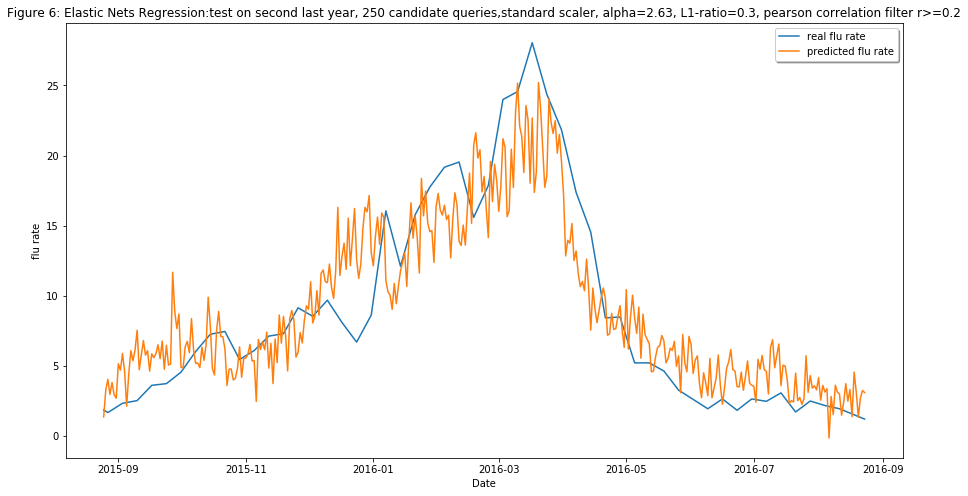

In [28]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:4018],y_pred2,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
plt.title("Figure 6: Elastic Nets Regression:test on second last year, 250 candidate queries,standard scaler, alpha=2.63, L1-ratio=0.3, pearson correlation filter r>=0.2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()